<a href="https://colab.research.google.com/github/Chang365/ESAA-25-1-assignments/blob/main/ESAA_25_2_1121_assinment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <딥러닝 파이토치 교과서> 5장 p.200-229

## 5.3 전이 학습

이미지넷처럼 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용하는 것

### 5.3.1 특성 추출 기법

- 합성곱층: 합성곱층과 풀링층으로 구성
- 데이터 분류기(완전언결층) : 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분

<사용 가능한 이미지 분류 모델>

- Xception
- Inception V3
- ResNet50
- VGG16
- VGG19
- MobileNet


In [1]:
!pip install opencv-python

In [2]:
# 5-12: 라이브러리 호출
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# 5-13: 이미지 데이터 전처리 방법 정의
data_path = '/content/drive/MyDrive/Colab Notebooks/chap05/data/catanddog/train'


transform=transforms.Compose(
    [
        transforms.Resize([256, 256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
])
train_dataset=torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader=torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

385


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


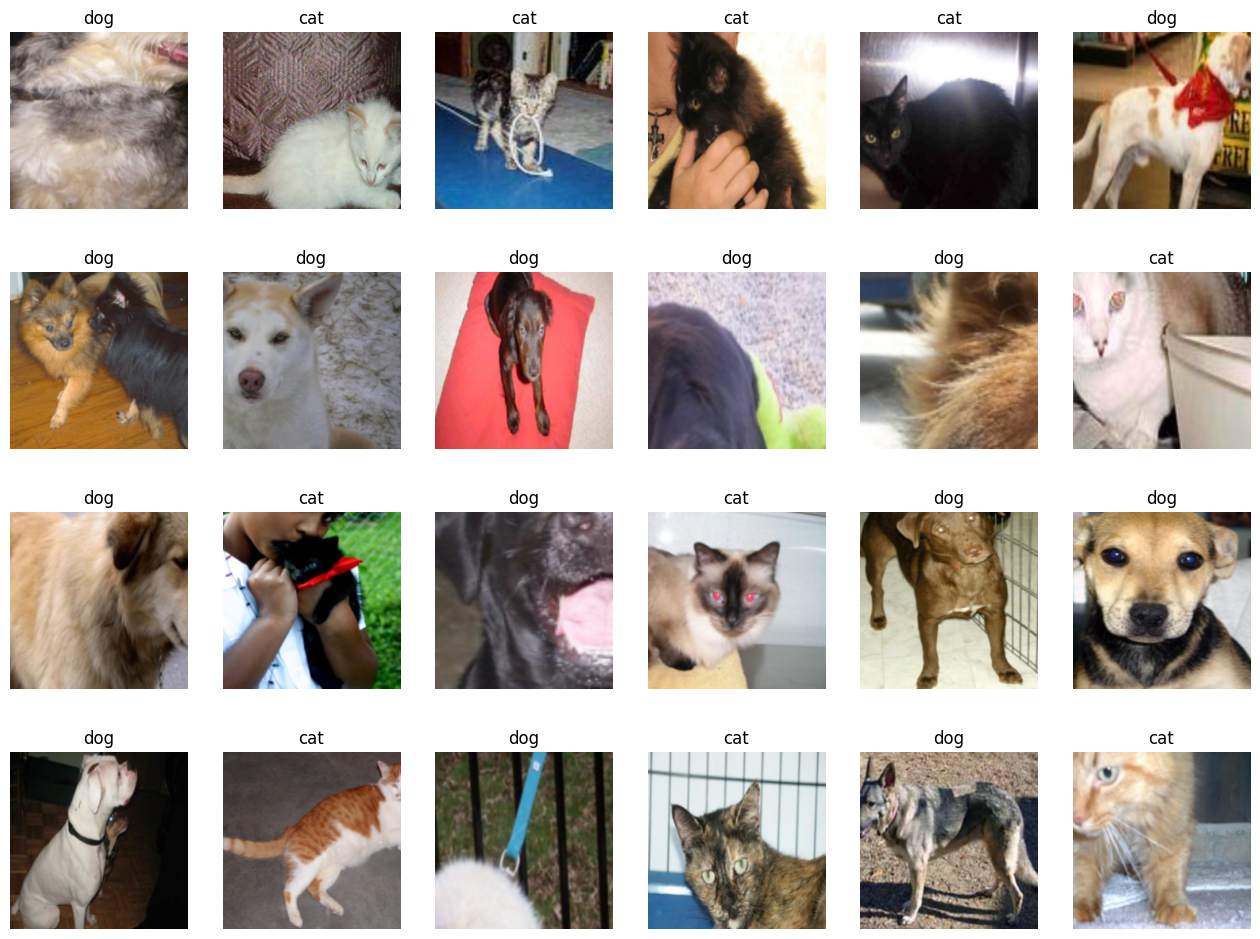

In [12]:
# 5-14: 학습에 사용될 이미지 출력
import numpy as np
samples, labels=next(iter(train_loader))
classes={0: 'cat', 1: 'dog'}
fig=plt.figure(figsize=(16,24))
for i in range(24):
    a=fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [13]:
# 5-15: 사전 훈련된 모델 내려받기

resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 28.7MB/s]


In [14]:
# 5-16: 사전 훈련된 모델의 파라미터 학습 유무 지정

def set_parameter_requires_grad(model, feature_extracting=True):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [15]:
# 5-17: ResNet18에 완전연결층 추가
resnet18.fc = nn.Linear(512, 2)

In [16]:
# 5-18: 모델의 파라미터 값 확인
for name, param in resnet18.named_parameters():
  if param.requires_grad:
    print(name, param.data)

fc.weight tensor([[-0.0262,  0.0349, -0.0196,  ...,  0.0157,  0.0352, -0.0166],
        [ 0.0062, -0.0362, -0.0183,  ..., -0.0091, -0.0318,  0.0290]])
fc.bias tensor([-0.0245,  0.0314])


In [17]:
# 5-19: 모델 객체 생성 및 손실 함수 정의

model = models.resnet18(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

model.fc = torch.nn.Linear(512,2)

for param in model.fc.parameters():
  param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# 5-20: 모델 학습을 위한 함수 생성

import os
import time
import torch

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13,
                is_train=True):

    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    save_dir = '/content/drive/MyDrive/Colab Notebooks/chap05/data/catanddog'
    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)

        save_path = os.path.join(save_dir, f'{epoch:02d}.pth')
        torch.save(model.state_dict(), save_path)

        print(f"Saved model → {save_path}\n")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                        time_elapsed % 60))
    print('Best ACC: {:.4f}'.format(best_acc))

    return acc_history, loss_history


In [21]:
# 5-21: 파라미터 학습 결과를 옵티마이저에 전달
params_to_update = []
for name, param in resnet18.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print("/t", name)

optimizer = optim.Adam(params_to_update)

/t fc.weight
/t fc.bias


In [22]:
# 5-22: 모델 학습
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion,
                                              optimizer, device)

Epoch 0/12
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loss: 0.0197 Acc: 0.7039
Saved model → /content/drive/MyDrive/Colab Notebooks/chap05/data/catanddog/00.pth

Epoch 1/12
----------
Loss: 0.0146 Acc: 0.8571
Saved model → /content/drive/MyDrive/Colab Notebooks/chap05/data/catanddog/01.pth

Epoch 2/12
----------
Loss: 0.0124 Acc: 0.8519
Saved model → /content/drive/MyDrive/Colab Notebooks/chap05/data/catanddog/02.pth

Epoch 3/12
----------
Loss: 0.0109 Acc: 0.8857
Saved model → /content/drive/MyDrive/Colab Notebooks/chap05/data/catanddog/03.pth

Epoch 4/12
----------
Loss: 0.0110 Acc: 0.8857
Saved model → /content/drive/MyDrive/Colab Notebooks/chap05/data/catanddog/04.pth

Epoch 5/12
----------
Loss: 0.0098 Acc: 0.8909
Saved model → /content/drive/MyDrive/Colab Notebooks/chap05/data/catanddog/05.pth

Epoch 6/12
----------
Loss: 0.0096 Acc: 0.9091
Saved model → /content/drive/MyDrive/Colab Notebooks/chap05/data/catanddog/06.pth

Epoch 7/12
----------
Loss: 0.0111 Acc: 0.8571
Saved model → /content/drive/MyDrive/Colab Notebooks/chap05/data/

In [24]:
# 5-23: 테스트 데이터 호출 및 전처리

test_path = '/content/drive/MyDrive/Colab Notebooks/chap05/data/catanddog/test'


transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]
)
test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)
print(len(test_dataset))

98


In [25]:
# 5-24: 테스트데이터 평가 함수 생성

def eval_model(model, dataloaders, device):
  since = time.time()
  acc_history = []
  best_acc = 0.0

  saved_models = glob.glob('/content/drive/MyDrive/Colab Notebooks/chap05/data/catanddog'+'*.pth')
  saved_models.sort()
  print('saved_model', saved_models)

  for model_path in saved_models:
    print('Loading model', model_path)

    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)
    running_corrects = 0

    for inputs, labels in dataloaders:
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.no_grad():
        outputs = model(inputs) # 'models(inputs)' 대신 'model(inputs)'으로 수정

      _, preds = torch.max(outputs.data, 1)
      preds[preds>=0.5] = 1
      preds[preds< 0.5] = 0
      running_corrects += preds.eq(labels.cpu()).int().sum()

    epoch_acc = running_corrects.double() / len(dataloaders.dataset)
    print('Acc: {:.4f}'.format(epoch_acc))

    if epoch_acc > best_acc:
      best_acc = epoch_acc
      acc_history.append(epoch_acc.item())
      print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,
                                                          time_elapsed % 60))
    print('Best ACC: {:.4f}'.format(best_acc))

    return acc_history

In [26]:
# 5-25: 테스트 데이터를 평가 함수에 적용

val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model []


ValueError: x, y, and format string must not be None

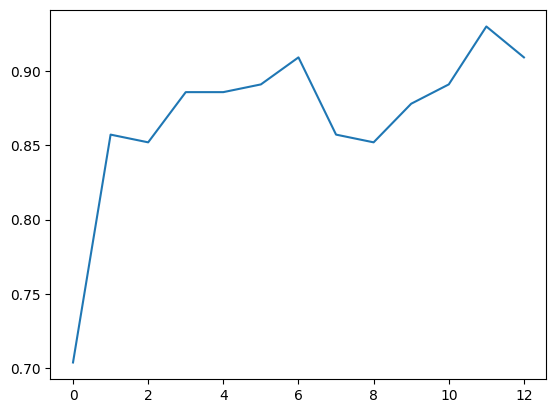

In [27]:
# 5-26: 훈련과 테스트 데이터의 정확도를 그래프로 확인

plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

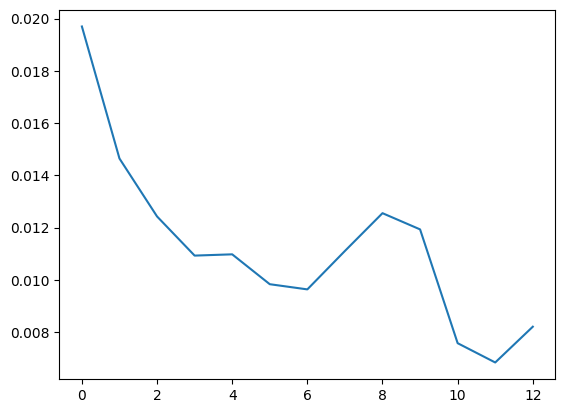

In [28]:
# 5-27: 훈련 데이터의 오차에 대한 그래프 확인

plt.plot(train_loss_hist)
plt.show()

In [29]:
# 5-28: 예측 이미지 출력을 위한 전처리 함수

def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image * (np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)))
  image = image.clip(0,1)
  return image

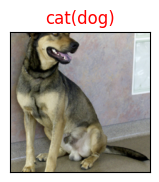

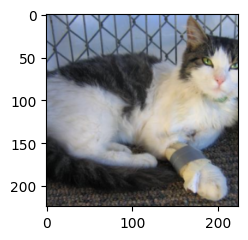

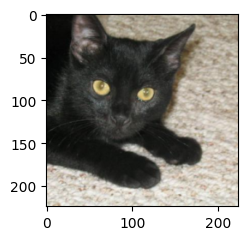

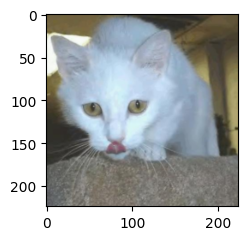

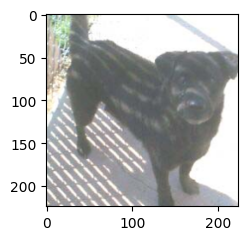

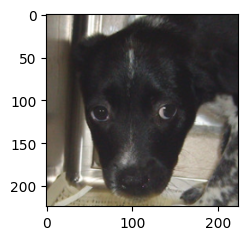

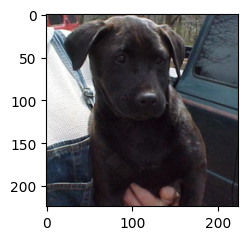

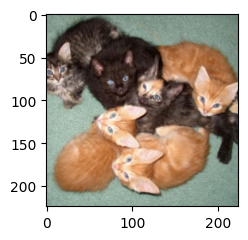

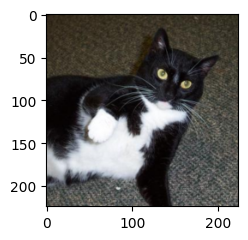

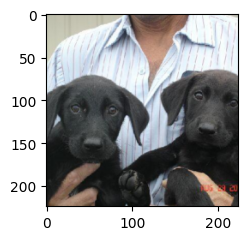

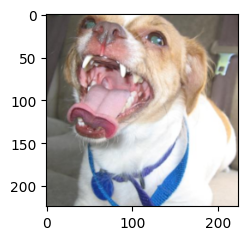

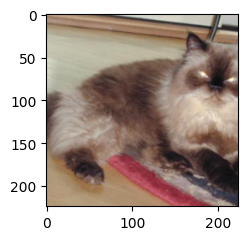

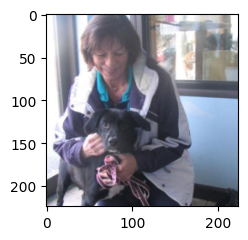

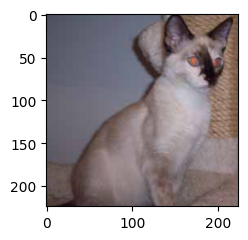

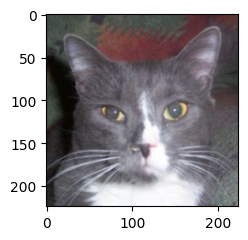

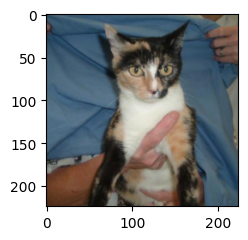

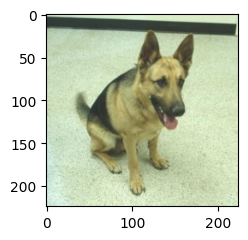

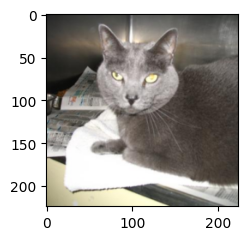

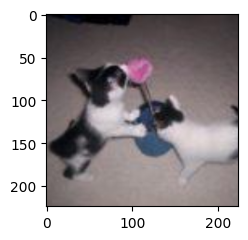

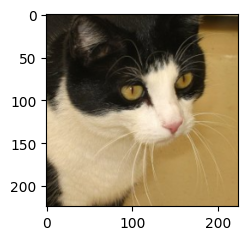

<Figure size 640x480 with 0 Axes>

In [30]:
# 5-29: 개와 고양이 예측 결과 출력
classes = {0:'cat', 1:'dog'}

daiter = iter(test_loader)
images, labels = next(daiter)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2,10,idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(f"{classes[labels[idx].item()]}")
  ax.set_title(f"{str(classes[preds[idx].item()])}({str(classes[labels[idx].item()])})",
               color=('green' if preds[idx]==labels[idx] else 'red'))
  plt.show()
  plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)